In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch_geometric.utils
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import time
from torch_geometric.logging import log
import os
from collections import Counter
import glob
from torch_geometric.utils.convert import from_networkx
import numpy as np

In [2]:
import sys  
sys.path.insert(1, '../../../../../evaluation/select_explanation/')
import dblp_select_explanation as select_explanation

In [3]:
#Save data.pt file by following https://github.com/ds-jrg/DiGNNExplainer/blob/main/baseline_explainers/d4explainer/data_preparation/imdb.ipynb
data = torch.load('imdb/processed/data.pt')
data

Data(edge_index=[2, 34212], x=[11616, 3], y=[11616], train_mask=[11616], val_mask=[11616], test_mask=[11616], node_type=[11616])

In [4]:
data.x

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [5]:
nodetypes = torch.unique(data.node_type)

In [6]:
device = 'cpu'
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             )
        self.conv2 = GCNConv(hidden_channels, hidden_channels,
                             )
        self.conv3 = GCNConv(hidden_channels, out_channels,
                             )

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        return x


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [11]:
def evaluate_gnn(graph):
    with torch.no_grad():
        model.eval()
        graph = graph.to(device)

        # The pred is not used for accuracy, the softmax is used
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        pred = out.argmax(dim=-1)

        # Getting class prediction probabilities from the softmax layer
        softmax = out.softmax(dim=-1)

        return softmax.tolist()

In [7]:
graphs_path = '../../../../../graph generator/diffusion models/sampled_graphs_diffusion/'
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'imdb_5to10/*.gexf')]))

Original no of graphs: 1367


In [8]:
avg_max_pred_list = []
max_pred_list = []
softmax_dict_list = []
class_graphid_list = []

In [12]:
for i in range(0,10):
    device = 'cpu'
    model = GCN(
        in_channels=data.x.shape[1],
        hidden_channels=64,
        out_channels=4,
    ).to(device)
    
    optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0),
    dict(params=model.conv3.parameters(), weight_decay=0)
    ], lr=0.005)   # Only perform weight-decay on first convolution.

    best_val_acc = test_acc = 0
    start_patience = patience = 100
    #times = []
    for epoch in range(1, 2000 + 1):
        loss = train()
        train_acc, val_acc, tmp_test_acc = test()
        if val_acc > best_val_acc:
            #best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch%100==0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        #times.append(time.time() - start)
    
        if (val_acc>best_val_acc):
            patience = start_patience
            best_val_acc = val_acc
    
        else:
            patience -= 1
            
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break 

    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    for filepath in glob.iglob(graphs_path + 'imdb_5to10/*.gexf'):
    
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]

        nodeId_list = [] 
        node_type_list = []
    
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
        
        #Metagraph checking is not required since we are converting to homogeneous
        small_graph = from_networkx(graph)
        
        small_graph.x = F.one_hot(torch.tensor(node_type_list), num_classes=len(nodetypes)).float()
        

        transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
        small_graph = transform(small_graph)

        
        softmax = evaluate_gnn(small_graph)
        softmax_dict[graph_id] = softmax

    print("No. of graphs evaluated: ",len(softmax_dict))
    avg_max_pred, max_pred, class_graphid = select_explanation.get_max_pred(softmax_dict,i)
    
    avg_max_pred_list.append(avg_max_pred)
    max_pred_list.append(max_pred)
    softmax_dict_list.append(softmax_dict)
    class_graphid_list.append(class_graphid)

Epoch: 100, Loss: 1.0724, Train: 0.3975, Val: 0.3950, Test: 0.3689
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1367
Run0 0.2966282069683075 0.46907180547714233 0.4438047707080841
Epoch: 100, Loss: 1.0803, Train: 0.3975, Val: 0.3950, Test: 0.3942
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1367
Run1 0.2931543290615082 0.4641944468021393 0.43668583035469055
Epoch: 100, Loss: 1.0769, Train: 0.3975, Val: 0.3950, Test: 0.3643
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1367
Run2 0.2899254560470581 0.48774629831314087 0.4054414629936218
Epoch: 100, Loss: 1.0822, Train: 0.3975, Val: 0.3950, Test: 0.3910
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  1367
Run3 0.2902701497077942 0.4706496000289917 0.44292116165161133
Epoch: 100, Loss: 1.0764, Train: 0.3975, Val: 0.3950, Test: 0.3643
S

In [13]:
avg_max_pred_list

[0.403168261051178,
 0.39801153540611267,
 0.3943710724512736,
 0.4012803037961324,
 0.3933314283688863,
 0.39480013648668927,
 0.41554076472918194,
 0.40849201877911884,
 0.3959151705106099,
 0.3991139531135559]

In [14]:
np.mean(avg_max_pred_list)

0.40040246446927397

In [28]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.006695559623436214


In [15]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

6

In [16]:
def plot_graph(graphid, max_pred, nodetype):
    
    graph=nx.read_gexf(graphs_path + 'imdb_5to10/' + graphid + '.gexf')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False,
             node_size=100)
    plt.show()

In [17]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]

In [18]:
class0_graphid

'graph738'

In [19]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]

Number of nodes:  7
graph id:  graph738
Max pred probability for class 0 is 0.30237966775894165


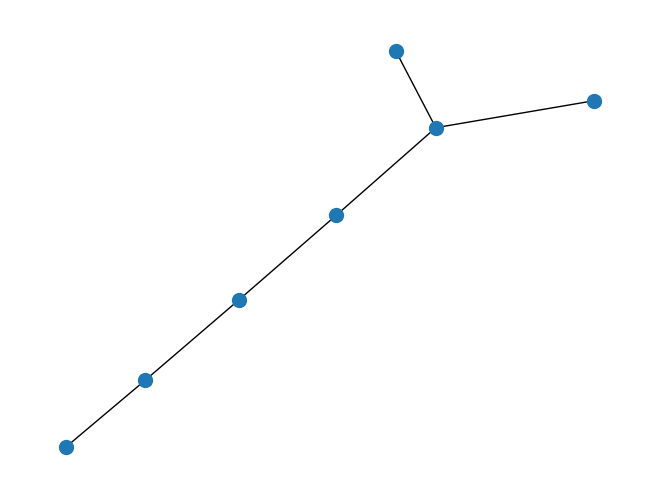

In [20]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0)

Number of nodes:  9
graph id:  graph1121
Max pred probability for class 1 is 0.4680881202220917


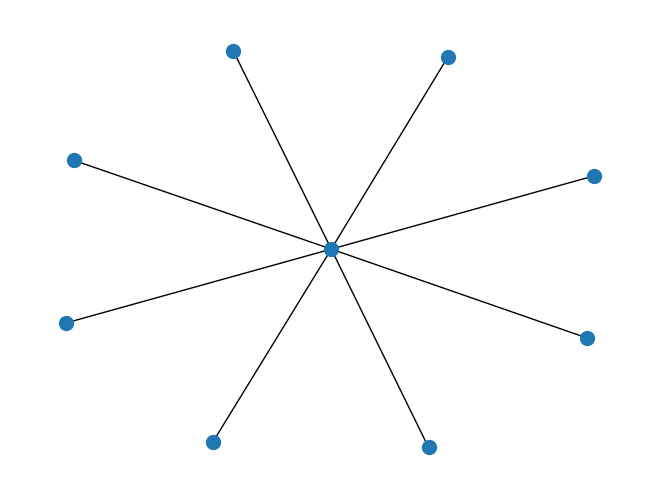

In [21]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1)

Number of nodes:  10
graph id:  graph1285
Max pred probability for class 2 is 0.47615450620651245


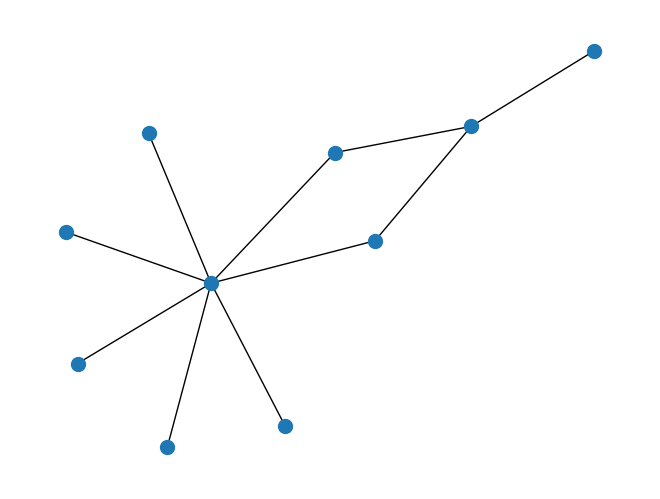

In [22]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2)

In [2]:
motifs_path = '../../../common_motifs/imdb_5to10/'
files_motif = os.listdir(motifs_path)

In [3]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../common_motifs/imdb_5to10/motif_real_10_0.gexf
../../../common_motifs/imdb_5to10/motif_real_10_1.gexf
../../../common_motifs/imdb_5to10/motif_real_10_2.gexf
../../../common_motifs/imdb_5to10/motif_real_10_3.gexf
../../../common_motifs/imdb_5to10/motif_real_10_4.gexf
../../../common_motifs/imdb_5to10/motif_real_5_0.gexf
../../../common_motifs/imdb_5to10/motif_real_5_1.gexf
../../../common_motifs/imdb_5to10/motif_real_5_2.gexf
../../../common_motifs/imdb_5to10/motif_real_5_3.gexf
../../../common_motifs/imdb_5to10/motif_real_5_4.gexf
../../../common_motifs/imdb_5to10/motif_real_6_0.gexf
../../../common_motifs/imdb_5to10/motif_real_6_1.gexf
../../../common_motifs/imdb_5to10/motif_real_6_2.gexf
../../../common_motifs/imdb_5to10/motif_real_6_3.gexf
../../../common_motifs/imdb_5to10/motif_real_6_4.gexf
../../../common_motifs/imdb_5to10/motif_real_7_0.gexf
../../../common_motifs/imdb_5to10/motif_real_7_1.gexf
../../../common_motifs/imdb_5to10/motif_real_7_2.gexf
../../../common_motifs/

In [25]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph=nx.read_gexf(graphs_path + 'imdb_5to10/' + graphid + '.gexf')
    
        faith_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)
            
            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            faith_score_list.append(x)

        class_faithfulness.append(np.mean(faith_score_list))

    return np.mean(class_faithfulness)

In [26]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print(np.mean(faithfulness_list))

Run0 0.8444444444444446
Run1 0.8444444444444446
Run2 0.8444444444444446
Run3 0.9
Run4 0.8444444444444446
Run5 0.8333333333333334
Run6 0.8444444444444446
Run7 0.8444444444444446
Run8 0.8444444444444446
Run9 0.9
0.8544444444444446


In [27]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.02301368353023106
